## Notebook

### Hybrid approach to extract ROI + deconvolution with Suite2p custom drawROI function

In [50]:
## 1. Import packages
import numpy as np
from skimage.io import imread

from suite2p import default_ops
from suite2p.gui.drawroi import masks_and_traces
from suite2p.io.binary import BinaryFile as BF
from suite2p.io.binary import BinaryRWFile as RW
from suite2p.detection import detection_wrapper
from suite2p.extraction import extraction_wrapper, oasis, preprocess

In [19]:
## Defining custom paths and values for `stat` and `ops`
## stat should be a list containing all the x/y pixels locations and the lambda values (1 in this case),
## median is just the center of the ROI

roi_fp = '../501b_project/data/y.ome.tiff'
rois = imread(roi_fp)
uniq_val = np.unique(rois.flatten())

stats_0 = []

for idx, val in enumerate(uniq_val[1:]):
    coordinates = np.where(rois == val)
    stats_0.append({
        'xpix' : coordinates[0].flatten(),
        'ypix' : coordinates[1].flatten(),
        'lam' : np.ones(coordinates[0].shape),
        'med' : [np.mean(coordinates[0].flatten()), np.mean(coordinates[1].flatten())]
        }
    )
    
ops = default_ops()

ops["fs"] = 30
ops['tau'] = 1.5
ops['reg_file'] = '../501b_project/data/f2_data.bin'
ops['Lx'] = 512
ops['Ly'] = 512

In [42]:
stat_orig = {}
F, Fneu, F_chan2, Fneu_chan2, spks, ops, manual_roi_stats = masks_and_traces(ops, stats_0, stat_orig)

Masks made in 1.26 sec.
Extracted fluorescence from 163 ROIs in 9000 frames, 34.21 sec.


/usr/people/tt1131/.conda/envs/suite2p/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/people/tt1131/.conda/envs/suite2p/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


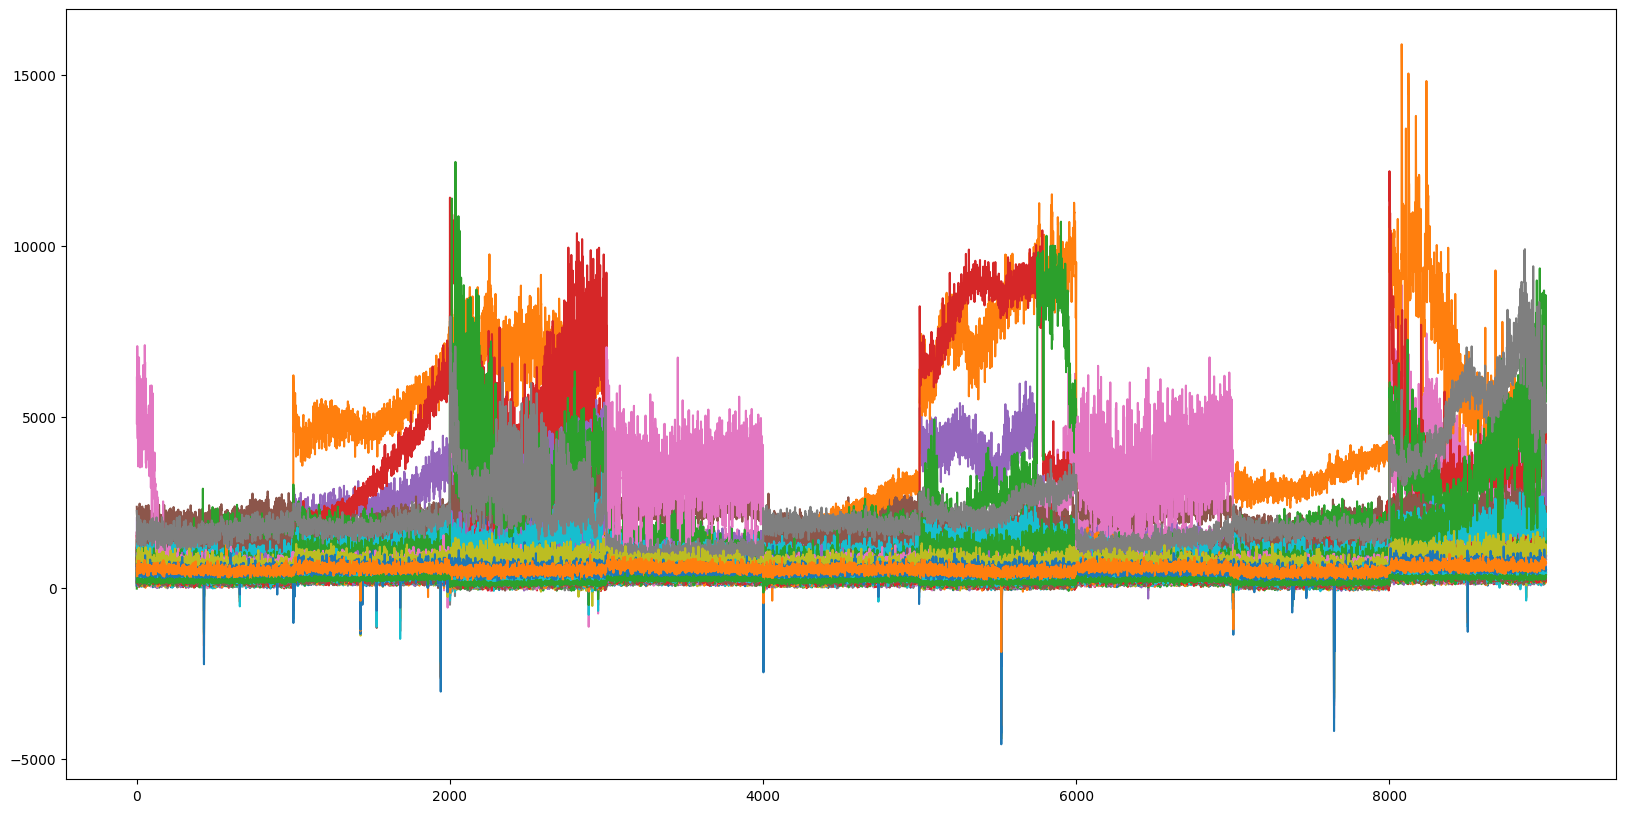

In [47]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (20, 10))

_ = plt.plot(F.T)

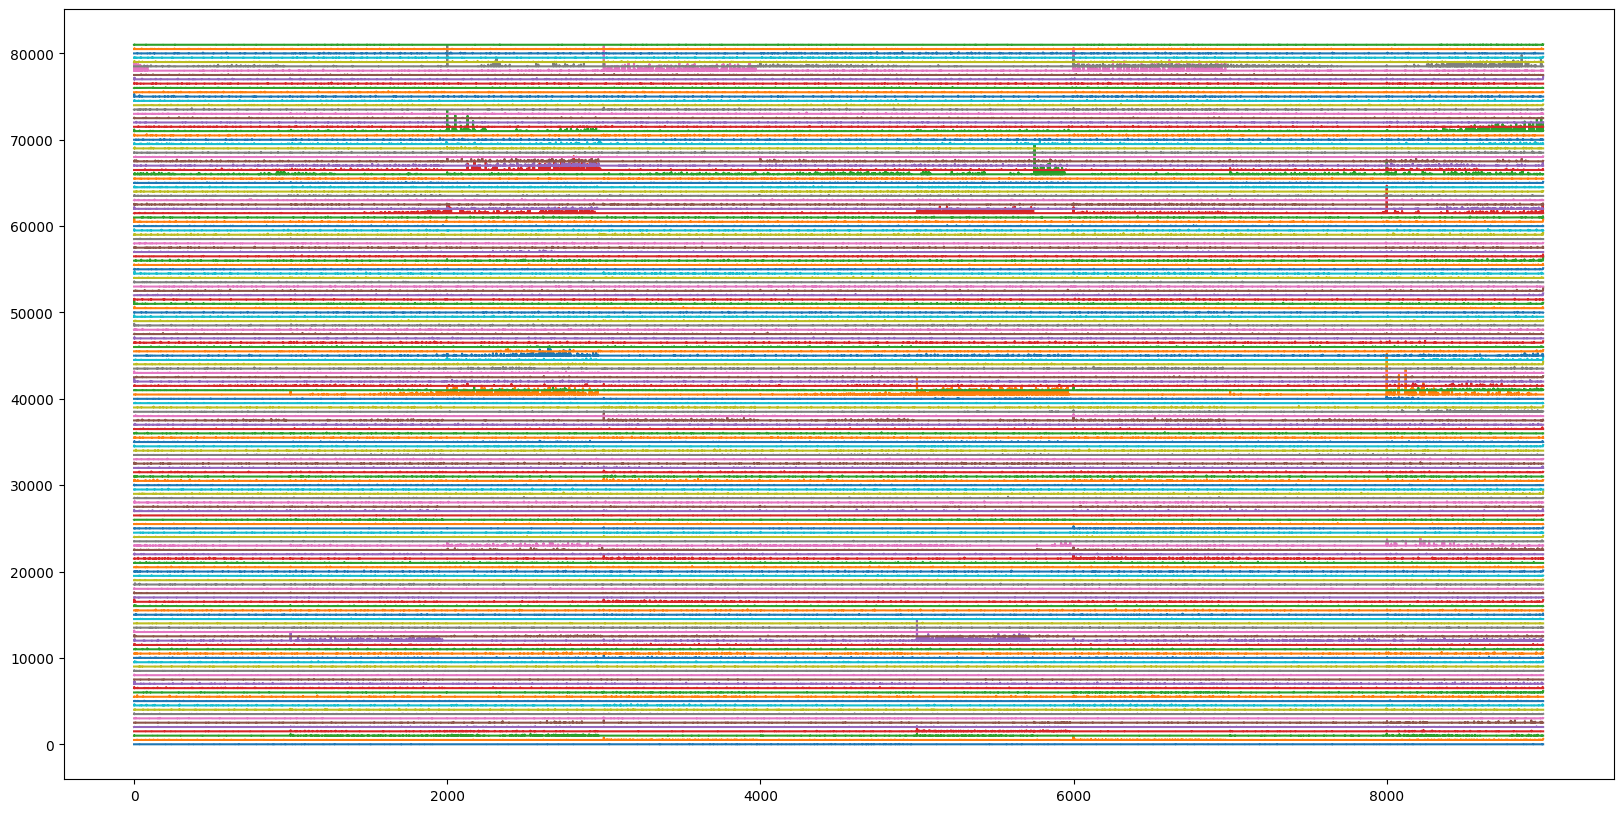

In [44]:
plt.figure(figsize = (20, 10))

for i in range(spks.shape[0]):
    _ = plt.plot(spks[i, :].T + i * 500)
#plt.ylim(0, 500)

In [45]:
fnames = ['rh_m_250_00001_00001',
 'rh_m_250_00002_00001',
 'rh_m_250_00003_00001',
 'rh_pulse_250_00001_00001',
 'rh_pulse_250_00002_00001',
 'rh_pulse_250_00003_00001',
 'rh_sine_250_00001_00001',
 'rh_sine_250_00002_00001',
 'rh_sine_250_00003_00001']
# finds = np.concatenate([[0], ops['frames_per_file']])
inds = [   0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
all_conds = {}
for i, fname in enumerate(fnames):
    all_conds[fname] = spks[:,inds[i]:inds[i+1]]

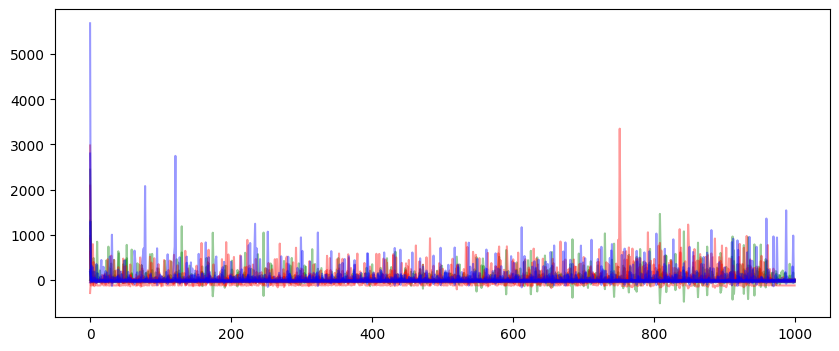

In [49]:
from sklearn.decomposition import PCA

fig,ax = plt.subplots(figsize=(10,4))
for fn in fnames:
    pcs = PCA(n_components=2).fit_transform(all_conds[fn].T)
    if 'pulse' in fn:
        c = 'r'
    elif 'sine' in fn:
        c = 'b'
    elif 'm' in fn:
        c = 'g' 
    ax.plot(pcs[:,:2], alpha=0.4, label=fn, c=c)
# ax.legend()
plt.show()

In [20]:
# ## Old hacking approach -> seems to not require detection wrapper :) 
# ops = default_ops()

# f_reg = RW(Ly = 512, Lx = 512, filename='../501b_project/data/f2_data.bin')
# # ops, stat = detection_wrapper(f_reg=f_reg, ops=ops)
# stat, F, Fneu, F_chan2, Fneu_chan2 = extraction_wrapper(stats_0, f_reg, ops=ops)

# dF = F.copy() - ops['neucoeff']*Fneu

# dF = preprocess(
#     F=dF,
#     baseline=ops['baseline'],
#     win_baseline=ops['win_baseline'],
#     sig_baseline=ops['sig_baseline'],
#     fs=ops['fs'],
#     prctile_baseline=ops['prctile_baseline']
# )
# spks = oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])

TypeError: 'int' object is not subscriptable